In [1]:
import time
import numpy as np
import cupy as cp
import pandas as pd
from typing import Union
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
# from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
g_drive_path = 'drive/MyDrive/Colab Notebooks/gpu_pa'
file_name = 'MLoGPU_data3_train.csv'
full_path = os.path.join(g_drive_path, file_name)
data = pd.read_csv(full_path, header=None)
print(data.head())
print(data.iloc[:, -1].value_counts())

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

          0         1         2         3         4         5         6    7
0  0.147035  1.264512 -0.474615 -0.543303 -1.091289  0.590143 -1.599582  4.0
1  0.559923  1.935253 -2.557251 -0.743111 -0.696480 -0.085936 -1.899705  6.0
2  0.766367 -0.496182  0.373866  0.170298 -0.544630 -0.592996  0.634732  4.0
3 -1.642146  0.426087  0.913809  1.397691  1.338306 -0.818356  0.367963  3.0
4 -0.334668  0.090717  1.608021  0.627002  2.644213 -0.367636  1.234998  4.0
7
4.0    1746
3.0    1317
5.0     664
2.0     133
6.0     119
1.0      18
7.0       3
Name: count, dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
class kNN:
    """k-Nearest Neighbors classifier for CPU and GPU implementation,
    uses NumPy for CPU, and CuPy and CUDA kernel for GPU."""

    def __init__(
            self,
            X: Union[np.ndarray, cp.ndarray],
            y: Union[np.ndarray, cp.ndarray],
            k: int,
            euclidean: bool = True,
            device: str = 'cpu'
            ) -> None:
        """Init constructor for kNN class.
        Args:
            X (np.ndarray): data set.
            y (np.ndarray): labels.
            k (int): number of neighbors.
            distance_metric (bool): Eucledian by default, Manhattan otherwise.
            device (str): 'cpu' or 'gpu'.
        Raises:
            ValueError: If device is not 'cpu' or 'gpu'.
        """
        if device.lower() not in ['cpu', 'gpu']:
            raise ValueError('Device must be either "cpu" or "gpu".')

        self.device = device.lower()
        self.k = k
        self.euclidean = euclidean

        if device.lower() == 'cpu':
            self.X = X
            self.y = y
        else:
            self.X = cp.asarray(X, dtype=cp.float32)
            self.y = cp.asarray(y, dtype=cp.int32)

        self.knn_kernel = cp.RawKernel(r'''
        extern "C" __global__
        void knn_kernel(const float* test_points,
                        const float* train_points,
                        const int* train_labels,
                        int num_test, int num_train,
                        int num_features, int k, int* pred_labels) {

            /* CUDA kernel for Euclidean distance calculation and array sorting.
            Args:
                test_points: data points to classify
                train_points: training data points
                train_labels: labels of training data points
                num_test: number of test points
                num_train: number of train points
                num_features: number of features
                k: number of nearest neighbors to find
                pred_labels: array to store predicted labels
            */

            int test_idx = blockDim.x * blockIdx.x + threadIdx.x;
            if (test_idx >= num_test) return;

            // Pointers for current query point
            const float* query = &test_points[test_idx * num_features];

            // lowest k arrays
            float k_lowest_dists[32];
            int k_lowest_labels[32];

            // populate k_lowest arrays with default values
            for (int i = 0; i < k; ++i) {
                k_lowest_dists[i] = 2e20f;  // large default values
                k_lowest_labels[i] = -2;    // negative default label
            }

            // for each training point
            for (int train_idx = 0; train_idx < num_train; ++train_idx) {
                const float* train = &train_points[train_idx * num_features];

                // euclidean distance
                float dist = 0.0f;
                // for each feature
                for (int f = 0; f < num_features; ++f) {
                    float diff = query[f] - train[f];
                    dist += diff * diff;
                }

                // update lowest k arrays
                if (dist < k_lowest_dists[k - 1]) {
                    // swap with last element if smaller
                    k_lowest_dists[k - 1] = dist;
                    k_lowest_labels[k - 1] = train_labels[train_idx];

                    // sort lowest k arrays
                    for (int j = k - 1; j > 0; --j) {
                        if (k_lowest_dists[j] < k_lowest_dists[j - 1]) {
                            // save to temp var
                            float temp_dist = k_lowest_dists[j];

                            // swap distances
                            k_lowest_dists[j] = k_lowest_dists[j - 1];
                            k_lowest_dists[j - 1] = temp_dist;

                            // swap labels
                            int temp_label = k_lowest_labels[j];
                            k_lowest_labels[j] = k_lowest_labels[j - 1];
                            k_lowest_labels[j - 1] = temp_label;
                        } else {
                            break;
                        }
                    }
                }
            }

            // majority voting
            int counter[32] = {0};
            int max_count = 0;
            int top_label = -2;

            for (int i = 0; i < k; ++i) {
                int curr_label = k_lowest_labels[i];
                counter[curr_label]++;
                if (counter[curr_label] > max_count) {
                    max_count = counter[curr_label];
                    top_label = curr_label;
                }
            }

            // output to global memory
            pred_labels[test_idx] = top_label;
        }
        ''', 'knn_kernel')


    def infer_kernel(self, x: cp.ndarray) -> cp.ndarray:
        """Inference from CUDA kernel.
        Args:
            x (cp.ndarray): data point(s).
        Returns:
            pred_labels (cp.ndarray): predicted labels.
        """
        test_points = cp.asarray(x, dtype=cp.float32)
        train_points = cp.asarray(self.X, dtype=cp.float32)
        train_labels = cp.asarray(self.y, dtype=cp.int32)

        n_test = x.shape[0]
        pred_labels = cp.empty(n_test, dtype=cp.int32)
        threads = 128
        blocks = (n_test + threads - 1) // threads

        self.knn_kernel(
            (blocks,), (threads,),
            (
                test_points, train_points, train_labels, n_test,
                self.X.shape[0], self.X.shape[1], self.k, pred_labels
            )
        )
        return pred_labels


    def get_distances(self, x: Union[np.ndarray, cp.ndarray]) -> cp.ndarray:
        """Get distances between input data point and training data set.
        Args:
            x (np.ndarray): data point.
        Returns:
            distances (cp.ndarray): list of distances.
        """
        # if self.device == 'cpu':
        distances = np.array([np.sqrt(np.sum((self.X - point) ** 2, axis=1)) for point in x])
        return distances


    def predict(self, x: Union[np.ndarray, cp.ndarray]) -> int:
        """Get prediction from kNN with weighted voting.

        Args:
            x (np.ndarray): data point.

        Returns:
            y_pred (int): predicted label.
        """
        if self.device == 'cpu':
            distances = self.get_distances(x)
            y_pred = []
            for d in distances:
                nearest = np.argsort(d)[:self.k]      # indices of k closest points
                closest_labels = self.y[nearest]      # actual labels
                counts = np.bincount(closest_labels)  # Count label occurrences
                chosen_label = np.argmax(counts)      # label with most votes
                y_pred.append(chosen_label)

        else:
            # inference from CUDA kernel
            y_pred = self.infer_kernel(x)

        return y_pred


    def evaluate(
            self,
            y_pred: Union[np.ndarray, cp.ndarray],
            y_test: Union[np.ndarray, cp.ndarray]
            ) -> float:
        """Get model accuracy.
        Args:
            X (np.ndarray): data set.
            y (np.ndarray): labels.
        Returns:
            accuracy (float): accuracy of the model.
        """
        if self.device == 'gpu':
            y_pred = y_pred - 1
            y_test = y_test - 1

            cm = cp.zeros((7, 7), dtype=cp.int32)

            for i in range(len(y_pred)):
                cm[y_pred[i], y_test[i]] += 1
            return cm

        else:
            return confusion_matrix(y_test, y_pred)


def plot_confusion_matrix(
        cm: Union[np.ndarray, cp.ndarray],
        labels: Union[np.ndarray, cp.ndarray], title: str
    ) -> None:
    """Plot confusion matrix using Seaborn.
    Args:
        cm (np.ndarray): confusion matrix.
        labels (np.ndarray): labels.
        title (str): title of the plot.
    """
    if isinstance(cm, cp.ndarray):  # Convert GPU array to CPU array
        cm = cp.asnumpy(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()


Average time: 0.2263 sec
Average accuracy: 0.5093


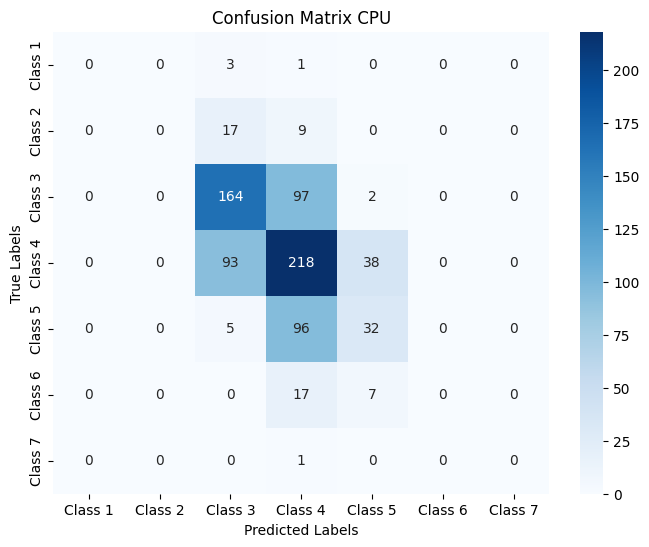

In [32]:
times_cpu = []
acc_cpu = []
avg_time_run_cpu =[]
for _ in range(10):
  temp =[]
  for k in range(1, 33):
      start_cpu = time.time()
      knn_cpu = kNN(X_train, y_train, k=k, device='cpu')
      y_pred = knn_cpu.predict(X_test)
      acc = np.mean(y_pred == y_test)
      time_cpu = time.time() - start_cpu
      times_cpu.append(time_cpu)
      acc_cpu.append(acc)
      temp.append(time_cpu)
  avg_time_run_cpu.append(np.mean(temp))

confusion_matrix_cpu = knn_cpu.evaluate(y_pred, y_test)
avg_time_cpu = np.mean(times_cpu)
avg_acc_cpu = np.mean(acc_cpu)
print(f'Average time: {round(avg_time_cpu, 4)} sec')
print(f'Average accuracy: {round(avg_acc_cpu, 4)}')
labels = [f'Class {i}' for i in range(1, 8)]
plot_confusion_matrix(confusion_matrix_cpu, labels, 'Confusion Matrix CPU')


Average time: 0.0022 sec
Average accuracy: 0.5074
Speedup: 104.82x


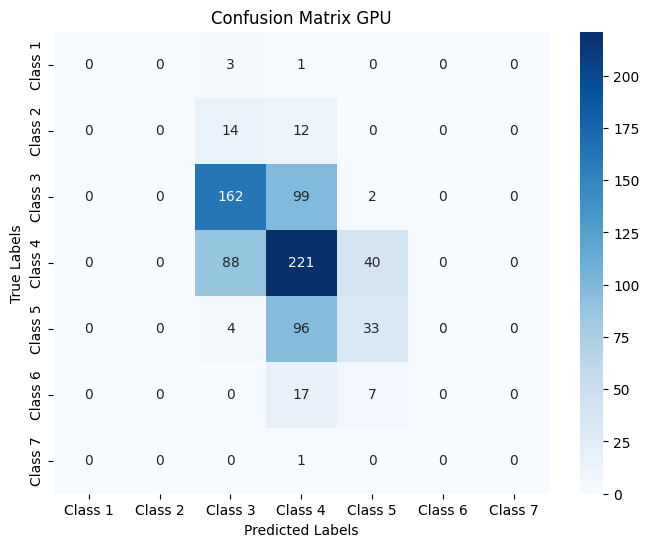

In [33]:
times_gpu = []
acc_gpu = []
avg_time_run_gpu = []
for _ in range(10):
  temp = []
  for k in range(2, 33):
      start_gpu = time.time()
      knn_gpu = kNN(X_train, y_train, k=k, device='gpu', euclidean=False)
      X_test_gpu = cp.asarray(X_test, dtype=cp.float32)
      y_test_gpu = cp.asarray(y_test, dtype=cp.int32)
      y_pred_gpu = cp.asarray(knn_gpu.predict(X_test), dtype = cp.int32)
      acc = cp.mean(y_test_gpu == y_pred_gpu)
      time_gpu = time.time() - start_gpu
      times_gpu.append(time_gpu)
      acc_gpu.append(acc)
      temp.append(time_gpu)
  avg_time_run_gpu.append(np.mean(temp))

confusion_matrix_gpu = knn_gpu.evaluate(y_test_gpu, y_pred_gpu)
avg_time_gpu = np.mean(times_gpu)
avg_acc_gpu = np.mean([a.get() if hasattr(a, 'get') else a for a in acc_gpu])


print(f'Average time: {round(avg_time_gpu, 4)} sec')
print(f'Average accuracy: {round(avg_acc_gpu, 4)}')
print(f'Speedup: {round((avg_time_cpu / avg_time_gpu), 2)}x')
plot_confusion_matrix(confusion_matrix_gpu, labels, 'Confusion Matrix GPU')

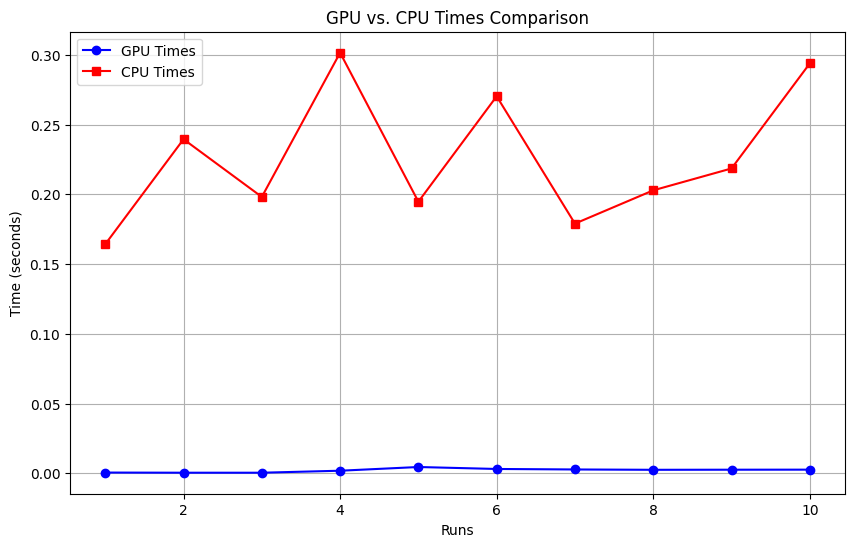

In [34]:
runs = range(1, len(avg_time_run_cpu) + 1)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(runs, avg_time_run_gpu, label='GPU Times', marker='o', color='blue')
plt.plot(runs, avg_time_run_cpu, label='CPU Times', marker='s', color='red')

# Adding labels and title
plt.xlabel('Runs')
plt.ylabel('Time (seconds)')
plt.title('GPU vs. CPU Times Comparison')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()
